In [1]:
card_name = 'q2only_test'

# Import

In [2]:
import sys, os
from glob import glob
sys.path.append('../lib')

In [3]:
import numpy as np
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [4]:
file_loc = {
# 'data' : '../data/cmsRD/Run2018D/B02DstMu_190517_BPH*.root',
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates/out*.root'
}

branches = ['q2', 'Est_mu', 'M2_miss',
            'mass_MuDst', 'cos_MuDst_vtxBest'
           ]

dSet = {}
for k, fn in file_loc.iteritems():
    dSet[k] = extarct_multiple(fn, branches=branches, flag=k)
    print k, ':', dSet[k]['Est_mu'].shape[0], 'candidates'

mu : 15963 candidates
tau : 7222 candidates


In [5]:
analysis_selection = {
'mass_MuDst'      : ['<', 5.280],
'cos_MuDst_vtxBest' : ['>', 0.98]
}

binning = {
'q2'      : [10, -2, 10.7]
# 'q2'      : [4, -2, 10.7]
# 'M2_miss' : [40/2, -5, 10]
# 'Est_mu'  : [30/2, 0.10, 2.500]
}

In [6]:
histo= {}
for k in file_loc.keys():
#     histo[k] = rt.TH3F('h_'+k, k, 
#                      binning['q2'][0], binning['q2'][1], binning['q2'][2],
#                      binning['M2_miss'][0], binning['M2_miss'][1], binning['M2_miss'][2],      
#                      binning['Est_mu'][0], binning['Est_mu'][1], binning['Est_mu'][2]
#                     )
    histo[k] = rt.TH1F(k, k, 
                     binning['q2'][0], binning['q2'][1], binning['q2'][2]
                    )

    d = dSet[k]
    sel = createSel(d, analysis_selection)
#     rtnp.fill_hist(histo[k], np.column_stack((d['q2'][sel], d['M2_miss'][sel], d['Est_mu'][sel])))
    rtnp.fill_hist(histo[k], d['q2'][sel])
    
# Add overflow in the last visible bin

In [7]:
rawR_inj = 0.2
N_B2mu_inj = 5000

sel = createSel(dSet['mu'], analysis_selection)
n_mu = np.random.poisson(lam=N_B2mu_inj)
idx = np.random.randint(0, np.sum(sel), size=(n_mu, ))
d_mu = dSet['mu']['q2'][sel]
d_mu = d_mu[idx]

sel = createSel(dSet['tau'], analysis_selection)
n_tau = np.random.poisson(lam=N_B2mu_inj*rawR_inj)
idx = np.random.randint(0, np.sum(sel), size=(n_tau, ))
d_tau = dSet['tau']['q2'][sel]
d_tau = d_tau[idx]

histo['data'] = rt.TH1F('dataObs', 'data obs', 
                        binning['q2'][0], binning['q2'][1], binning['q2'][2]
                       )
rtnp.fill_hist(histo['data'], np.concatenate((d_mu, d_tau)))
print n_mu, n_tau
print 'r_toy = {:.2f}%'.format(100.*n_tau/n_mu)

4965 967
r_toy = 19.48%


Scale according expectation and save file

In [8]:
histo['mu'].Scale(1./histo['mu'].Integral())
histo['tau'].Scale(1./histo['tau'].Integral())

In [9]:
histo_file_loc = '../data/_root/histos4combine/{}.root'.format(card_name)
tf = rt.TFile(histo_file_loc, 'recreate')
for k,v in histo.iteritems():
    v.Write()
tf.Close()

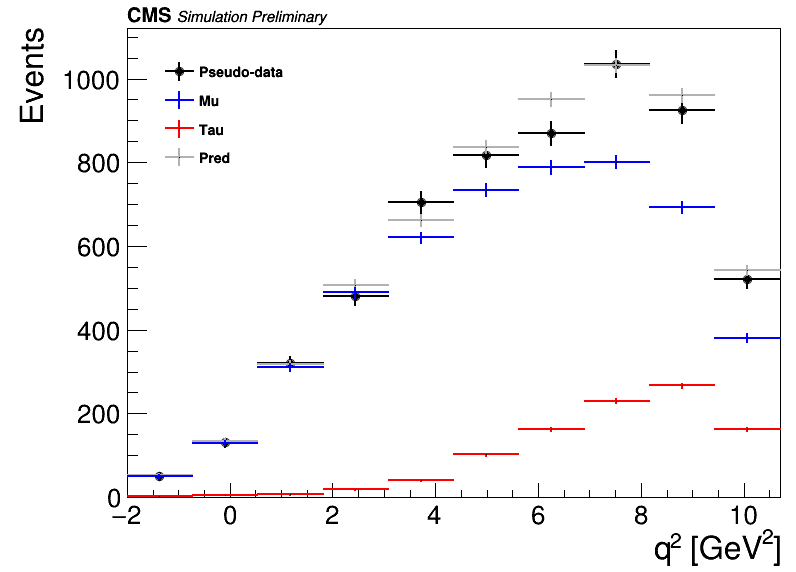

In [10]:
leg = rt.TLegend(0.2, 0.7, 0.4, 0.9)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

histo['data'].Sumw2()
histo['data'].SetMarkerColor(1)
histo['data'].SetMarkerStyle(20)
histo['data'].SetLineColor(1)
histo['data'].SetXTitle('q^{2} [GeV^{2}]')
histo['data'].SetYTitle('Events')
leg.AddEntry(histo['data'], 'Pseudo-data', 'lep')

histo['mu'].Scale(N_B2mu_inj/histo['mu'].Integral())
histo['mu'].SetLineColor(4)
leg.AddEntry(histo['mu'], 'Mu', 'lep')

histo['tau'].Scale(N_B2mu_inj*rawR_inj/histo['tau'].Integral())
histo['tau'].SetLineColor(2)
leg.AddEntry(histo['tau'], 'Tau', 'lep')

h_sum = histo['mu'].Clone('h_sum')
h_sum.Add(histo['tau'])
h_sum.SetLineColor(16)
leg.AddEntry(h_sum, 'Pred', 'lep')

CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas(CMS_lumi, [histo['data'], h_sum, histo['mu'], histo['tau']], 'same')
leg.Draw()
c.Draw()

# Write the card

In [11]:
sig_processes = ['tau', 'mu']

In [12]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [13]:
# number of different categories
card = 'imax 1\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(sig_processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '-------------------------------\n'

In [14]:
card += 'shapes * cat1 ' + histo_file_loc + ' $PROCESS $PROCESS__$SYSTEMATIC\n'
card += '-------------------------------\n'

In [15]:
card += 'bin cat1\n'
card += 'observation {:.0f}\n'.format(histo['data'].Integral())
card += '-------------------------------\n'

In [16]:
card += 'bin ' + ' '.join(['cat1']*2) + '\n'
card += 'process ' + ' '.join(sig_processes) + '\n'

# Zero or negative for sig and positive for bkg
card += 'process ' + '0 1\n'

# Expected rate
rate_str = ' 1'*len(sig_processes) #Both tau and mu are set to 1 because rate is floated below
card += 'rate ' + rate_str + '\n'
card += '-------------------------------\n'

Add additional rate parameters

In [17]:
card += 'N_B2mu rateParam cat1 tau {}\n'.format(N_B2mu_inj)
card += 'N_B2mu rateParam cat1 mu {}\n'.format(N_B2mu_inj)
card += '-------------------------------\n'

MC statistic systematics

In [18]:
card += '* autoMCStats 0 1 1\n'
card += '-------------------------------\n'

In [19]:
print card

imax 1
jmax 1
kmax *
-------------------------------
shapes * cat1 ../data/_root/histos4combine_q2only_test.root $PROCESS $PROCESS__$SYSTEMATIC
-------------------------------
bin cat1
observation 5855
-------------------------------
bin cat1 cat1
process tau mu
process 0 1
rate  1 1
-------------------------------
N_B2mu rateParam cat1 tau 5000
N_B2mu rateParam cat1 mu 5000
-------------------------------
* autoMCStats 0 1 1
-------------------------------



In [20]:
fc.write(card)
fc.close()

### Create output directory

In [21]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

### Run the Maximum Likelyhood fit

In [22]:
cmd = 'combine'
cmd += ' -M FitDiagnostics'
cmd += ' --robustFit 1'
cmd += ' --skipBOnlyFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties'
cmd += ' --plots'
cmd += ' --verbose 9'

In [23]:
print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

combine -M FitDiagnostics --robustFit 1 --skipBOnlyFit -d cards/q2only_test.txt -D dataObs --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu -n q2only_test --out results/q2only_test --saveShapes --saveWithUncertainties --plots --verbose 9


0


   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Turning on runtime-define MINIMIZER_analytic
import (../data/_root/histos4combine_q2only_test.root,dataObs) -> shapeBkg_dataObs_cat1

import (../data/_root/histos4combine_q2only_test.root,mu) -> shapeBkg_mu_cat1

import (../data/_root/histos4combine_q2only_test.root,tau) -> shapeSig_tau_cat1

RooWorkspace::factory('CMS_th1x[0,10]')
 --->  <ROOT.RooRealVar object ("CMS_th1x") at 0x5601ef0>
RooWorkspace::factory('CMS_channel[cat1=0]')
 --->  <ROOT.RooCategory object ("CMS_channel") at 0x80bdad0>
recyling (cat1,dataObs,) -> shapeBkg_dataObs_cat1

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(shapeBkg_dataObs_cat1): fit range of variable CMS_th1x expanded to nearest bin boundaries: [0,10] --> [0,10]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset dataObs
Created combined d

Using shapes: qui si parra' la tua nobilitate
Will use binning variable CMS_th1x with 10 bins
Will use category 'CMS_channel' to identify the 1 channels
Creating pdfs for individual modes (1): .    1done.
Importing combined pdf model_s
Setting variable 'MH' in workspace to the higgs mass 120
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-8kmAa1.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Info in <Minuit2>: Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate
Error in <TList::Clear>: A list is accessing an object (0x92fc3d4) already deleted (list name = TList)
Info in <TCanvas::Print>: png file results/q2only_test/cat1_CMS_th1x_prefit.png has been created
Info in <Minuit2>: Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate
Error in <TList::Clear>: A list is accessing an object (0x92fc924) already deleted (list name = TList)
Info in <TCanvas::Print>: png file results/q2only_

In [24]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.root'.format(card_name))[0])
c, d, u, _ = f['limit']['limit'].array()
print '{:.3f} +{:.3f}/-{:.3f}'.format(c, u-c, c-d)

0.176 +0.031/-0.030


### Run the Goodness of fit test

Run the observed test stat value

In [25]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 9'

In [26]:
print cmd
os.system(cmd)

combine -M GoodnessOfFit -d cards/q2only_test.txt -D dataObs -n Obs -t 0 -s -1 --toysNoSystematics --algo=saturated --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu --plots --verbose 9


0


Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> Using OpenSSL to get a really random seed 
>>> Used OpenSSL to get a really random seed 725046166
Turning on runtime-define MINIMIZER_analytic
import (../data/_root/histos4combine_q2only_test.root,dataObs) -> shapeBkg_dataObs_cat1

import (../data/_root/histos4combine_q2only_test.root,mu) -> shapeBkg_mu_cat1

import (../data/_root/histos4combine_q2only_test.root,tau) -> shapeSig_tau_cat1

RooWorkspace::factory('CMS_th1x[0,10]')
 --->  <ROOT.RooRealVar object ("CMS_th1x") at 0x49c65d0>
RooWorkspace::factory('CMS_channel[cat1=0]')
 --->  <ROOT.RooCategory object ("CMS_channel") at 0x749f4e0>
recyling (cat1,dataObs,) -> shapeBkg_dataObs_cat1

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(shapeBkg_dataObs_cat1): fit range of variable CMS_th1x expanded to nearest bin boundaries: [0,10] --> [0,10]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset dataO

Using shapes: qui si parra' la tua nobilitate
Will use binning variable CMS_th1x with 10 bins
Will use category 'CMS_channel' to identify the 1 channels
Creating pdfs for individual modes (1): .    1done.
Importing combined pdf model_s
Importing combined pdf model_b
Setting variable 'MH' in workspace to the higgs mass 120
RooSimultaneousOpt: number of channel masks must equal number of channels


Run the test stat toy distribution

In [27]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 500'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 1'

In [28]:
print cmd
os.system(cmd)

combine -M GoodnessOfFit -d cards/q2only_test.txt -D dataObs -n Toys -t 500 -s -1 --toysNoSystematics --algo=saturated --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu --plots --verbose 9


0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Using shapes: qui si parra' la tua nobilitate
Will use binning variable CMS_th1x with 10 bins
Will use category 'CMS_channel' to identify the 1 channels
Creating pdfs for individual modes (1): .   done.
Importing combined pdf model_s
Importing combined pdf model_b
Setting variable 'MH' in workspace to the higgs mass 120
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal number of channels
RooSimultaneousOpt: number of channel masks must equal

Combine them to get the p-value

In [29]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]

In [30]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)

p-value: 29.0%


In [31]:
# cmd = 'combineTool.py'
# cmd += ' -M CollectGoodnessOfFit'
# cmd += ' --mass 120'
# cmd += ' -o gof.json'
# cmd += ' --input {} {}'.format(name_obs, name_toys)
# print cmd
# os.system(cmd)
# os.system('plotGof.py gof.json -o gof --mass 120.0')

In [32]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv *.dot {}/'.format(outdir))
os.system('mv *.out {}/'.format(outdir))

0